In [2]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from get_utils import get_data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import scipy.stats as stats
from tdr import build_tdr, project_onto_map, orth_wrt_tdr
import torch as th
#%matplotlib widget
#%matplotlib qt
%matplotlib inline

In [21]:
folder_name = 'Sim_all'
seed = 100

T = pd.DataFrame()

N_idx = 15 # 16
F_idx = 24 # 25

t_disturb_hidden = N_idx/100

loss_type = 'lateral'
is_channel = False

for mn in range(0,20):
    model_name = "model{:02d}".format(mn)

    # 1. Estimating TDR axes
    U2 = get_data(folder_name,model_name,{'NF1':[0]},[0],
                  batch_size=300,catch_trial_perc=0,condition='train',go_cue_random=False,seed=seed)#batch_size=300,catch_trial_perc=0,condition='train',go_cue_random=False,seed=seed
    N = np.array(U2[0]['all_hidden'])[:,N_idx,:]
    X = np.array(U2[0]['endpoint_force'])[:,F_idx,:]

    tdr = build_tdr(X,N)

    # 2. calculate uniform shift
    U = get_data(folder_name,model_name,{'NF1':[0],'FF1':[8]},[0,8])
    data = []
    for i in range(len(U)):
        data.append(np.array(U[i]['all_hidden'])[:,N_idx,:])
    
    us = np.mean(data[1]-data[0],axis=0).reshape(-1,1)
    us = orth_wrt_tdr(us,tdr)


    # 3. perturb hidden
    d_hidden = th.from_numpy(us.T*1) # 0.6

    # now lets perturb or not and calculate the saving in behavior
    data_p, loss_p = get_data(folder_name,model_name,{'NF2':[0]},[8],
                              is_channel=is_channel,disturb_hidden=True,t_disturb_hidden=t_disturb_hidden,d_hidden=d_hidden,return_loss=True,batch=None) # ,batch=[3000]

    data_np, loss_np = get_data(folder_name,model_name,{'NF1':[0],'NF2':[0]},[8,8],
                                is_channel=is_channel,return_loss=True,batch=[None,None]) #,batch=[None,3000]
    
    loss_ff1 = loss_np[0][loss_type].item()
    loss_ff2_np = loss_np[1][loss_type].item()
    loss_ff2_p = loss_p[0][loss_type].item()

    d = {'m':[mn]*3,'loss':[loss_ff1,loss_ff2_np,loss_ff2_p],'phase':['ff1','ff2','ff2_p']}
    T = pd.concat([T,pd.DataFrame(d)],ignore_index=True)

    # # plot
    # n_fig = 1
    # fig,ax = plt.subplots(1,n_fig,figsize=(7*n_fig,5))
    # ax = [ax]

    # plot.plot_simulations(ax[0],xy=data_np[1]['xy'],target_xy=data_np[1]['tg'],vel=None,plot_lat=False)
    # plot.plot_simulations(ax[0],xy=data_p[0]['xy'],target_xy=data_p[0]['tg'],vel=None,plot_lat=False,cmap='plasma')

    # fig, ax = plot.plot_activation(data_p[0]['all_hidden'],data_p[0]['all_muscle']-data_np[1]['all_muscle'],figsize=(15,15))

    # #fig, ax = plot.plot_force([data_np[1],data_p[0]],['np','p'],figsize=(10,15))

T-statistic: 3.0708800650407184
P-value: 0.006290066159525833


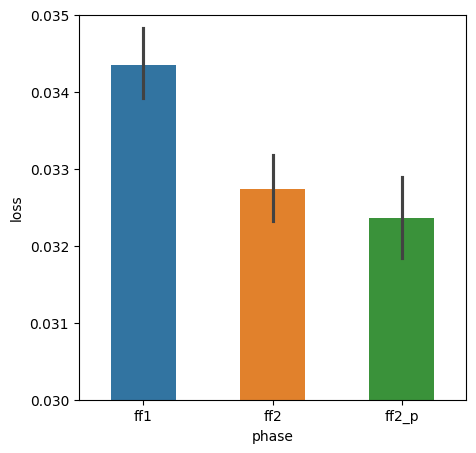

In [22]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

ax = sb.barplot(x='phase',y='loss',data=T,hue='phase',width=0.5)

#ax.set_ylim([33,37])
ax.set_ylim([0.03,0.035])
#ax.set_ylim([14,16])

L = T.pivot_table(index='m',columns='phase',values='loss')
t_statistic, p_value = stats.ttest_rel(L['ff2'],L['ff2_p'])
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -3.261950476481988
P-value: 0.004102022491171881


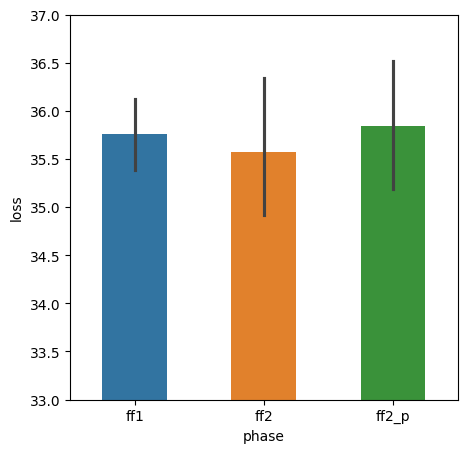

In [31]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

ax = sb.barplot(x='phase',y='loss',data=results,hue='phase',width=0.5)

ax.set_ylim([33,37])
#ax.set_ylim([0.03,0.035])
#ax.set_ylim([14,16])

T = results.pivot_table(index='m',columns='phase',values='loss')
t_statistic, p_value = stats.ttest_rel(T['ff2'],T['ff2_p'])
print("T-statistic:", t_statistic)
print("P-value:", p_value)

In [20]:
t_statistic, p_value = stats.ttest_rel(T['ff2'],T['ff2_p'])

In [38]:
t_statistic, p_value = stats.ttest_rel(T['ff1'],T['ff2'])
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 0.927251732376347
P-value: 0.3654257640171489
